In [1]:
# I will only use a 'fake' brain for this one, only results are actions 0 - 4
# This means I will start with an untrained text_dec and text_enc (though I will steal the img_enc from the old brain)
# If this proves too hard, I will start with an easier task

# This notebook will attempt actual PPO as a test study.
# If I want this for the actual system, I may use a 'burn-in' phase which includes making the relevant actions have non-negligible probability,
# and THEN launching the PPO

In [2]:
from game import *

pygame 2.6.1 (SDL 2.28.4, Python 3.12.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
game_settings = BIG_tool_use_advanced_2_5
game_settings.gameSize = 224 # for compatibility with brain's expected size
G = discreteGame(game_settings) # kind of a waste; will only call this object to generate random versions of itself

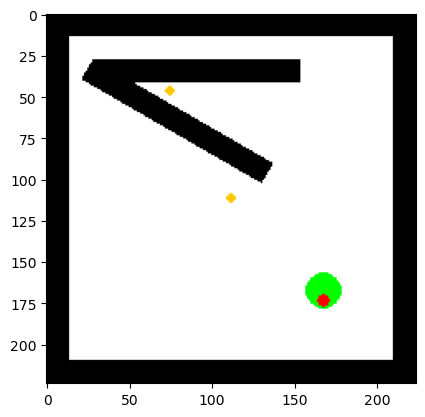

In [4]:
import matplotlib.pyplot as plt
plt.imshow(G.getData())

In [5]:
from RL_helper import *

In [6]:
from visual_transformer import *
device = torch.device('cuda:1') # doing this on the P40

In [7]:
def quick_display(torch_img):
    clean = torch_img.detach().cpu()
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy()
    plt.imshow(array)

In [8]:
# Ok, on to RL-specifics things

In [9]:
symbol_action_map

{1: 1, 3: 3, 4: 4, 108: 2}

In [10]:
# THis work for the full brain, but I am rewriting this for this experiment

In [11]:
symbol_action_map = {1: 1, 2: 2, 3: 3, 4: 4}
symbol_action_map

{1: 1, 2: 2, 3: 3, 4: 4}

In [12]:
# Next, I need to set up the brain itself
old_brain = DefaultAgentBrain()
old_brain.load_state_dict(torch.load('brain_checkpoints/brain_weights_tutorial1_v3_batch95000.pth', weights_only=True, map_location='cpu'))

brain = DefaultAgentBrain(5)
brain.img_enc = old_brain.img_enc
brain.img_dec = old_brain.img_dec
brain = brain.to(device)

In [13]:
# I'm starting to regret feeding the traces in at all
# I should really just have a single 'prompt' like "what is the best action here?"
# However, I don't feel like rewriting RL_helper just for this experiment, so this is what we are dealing with.
# Hopefully PPO will still work.

In [14]:
#buff = GameOutputBuffer(brain, brain.evaluate_text, gamma=0.99, tau=0.97, default_batch_size=8)

In [15]:
#buff.get_device()

In [16]:
#buff.fill(G)

In [17]:
#buff.__dict__

In [18]:
#buff = buff.to('cpu')

In [19]:
#buff.__dict__

In [20]:
from RL_logic_solver import * # convenient way to get fake, logical traces

In [21]:
def average_return(bb):
    """The average return (at the end of the seeds alone) from a buffer-buffer"""
    s = torch.zeros(bb[0].returns[:, 0].size(), device = bb[0].returns[:, 0].device)
    for b in bb:
        #s += bb[0].returns[:, 0]
        s += b.returns[:, 0]
    return torch.sum(s).item()/(len(bb) * bb[0].returns.size()[0])

In [35]:
def get_bb(num_buffers=64, batch_size=1, start_with_guide=True):
    bb = []
    brain.eval()
    for i in range(num_buffers):
        print(i)
        # In this case, we are only training the 'dopamine' layer on the val training loop
        buff = GameOutputBuffer(brain, brain.evaluate_text, gamma=0.99, tau=0.97, default_batch_size=batch_size)
        if start_with_guide and (i == 0):
            fake_data_fill(buff, G, batch_size, device=device) # This one guide is the only difference between this and the main one.
        else:
            buff.fill(G, num_games=batch_size)
        buff.cpu()
        bb.append(buff)
        #print(buff.traces)
    score = average_return(bb)
    score_tensor = torch.tensor([score], device=device)
    for i in range(num_buffers):
        print(i)
        buff = bb[i]
        buff.to(device)
        buff.use_values(score_tensor) # computes values tensor and gae's
        buff.cpu()
    return bb

In [29]:
buff = GameOutputBuffer(brain, brain.evaluate_text, gamma=0.99, tau=0.97, default_batch_size=1)

In [30]:
fake_data_fill(buff, G, 1, device=device)

In [32]:
buff.cpu()

In [33]:
buff.traces

tensor([[0, 4, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [34]:
buff.returns

tensor([[0.9415, 0.9510, 0.9606, 0.9703, 0.9801, 0.9900, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

In [27]:
#buff.values

In [36]:
bb = get_bb(3, 8)

0
1
2
0
1
2


In [29]:
#bb[0].traces

In [30]:
mse_loss = nn.MSELoss()

In [31]:
def nvidia_smi_spoof(device=device):
    return torch.cuda.memory_allocated() / (1024 ** 3)

In [32]:
policy_optimizer = optim.Adam(list(brain.text_enc.parameters()) + list(brain.text_dec.parameters()), lr=0.00001, eps=1e-9)
policy_epochs = 4
epochs = policy_epochs

In [33]:
def train_policy(policy_optimizer, epochs, buffer_buffer, policy_clip_range=0.1, entropy_loss_weight=0.01):
    for epoch in range(epochs):
        print(f"==========Epoch {epoch}=====================")
        #print(nvidia_smi_spoof())
        brain.train()
        #print(nvidia_smi_spoof())
        train_loss = 0
        random.shuffle(buffer_buffer)
        i = 0
        for buffer in buffer_buffer:
            i += 1
            buffer.to(device)
            #print(nvidia_smi_spoof())
            policy_optimizer.zero_grad()
            #print(nvidia_smi_spoof())
            logpas, entropies = buffer.get_probabilities_and_entropies(evaluation=False)
            #print(nvidia_smi_spoof())
            ratios = (logpas - buffer.logpas).exp()
            #print(nvidia_smi_spoof())
            pi_obj = buffer.gaes * ratios
            #print(nvidia_smi_spoof())
            pi_obj_clipped = buffer.gaes * ratios.clamp(1.0 - policy_clip_range,
                                                       1.0 + policy_clip_range)
            #print(nvidia_smi_spoof())
            policy_loss = -torch.min(pi_obj, pi_obj_clipped).mean()
            #print(nvidia_smi_spoof())
            entropy_loss = -entropies.mean() * entropy_loss_weight
            #print(nvidia_smi_spoof())
            loss = policy_loss + entropy_loss
            #print(nvidia_smi_spoof())
            loss.backward()
            #print(nvidia_smi_spoof())
            policy_optimizer.step()
            #print(nvidia_smi_spoof())
            train_loss += loss.item()
            #print(nvidia_smi_spoof())
            buffer.cpu()
            #print(nvidia_smi_spoof())
            torch.cuda.empty_cache()
            print(f"episode {i}, policy loss {loss.item()}\n")
        del loss, logpas, entropies, ratios, pi_obj, pi_obj_clipped, policy_loss, entropy_loss
        policy_optimizer.zero_grad()
        #print(nvidia_smi_spoof())
        print(f"Policy train loss in epoch {epoch}:{train_loss / (len(buffer_buffer))}")
#train_policy(policy_optimizer, policy_epochs, buffer_buffer, policy_clip_range, entropy_loss_weight)

In [34]:
#torch.cuda.empty_cache()

In [35]:
#train_policy(policy_optimizer, 1, bb[:4])#, policy_clip_range, entropy_loss_weight)

In [36]:
#train_policy(policy_optimizer, 2, bb[4:8])#, policy_clip_range, entropy_loss_weight)

In [37]:
#policy_optimizer.zero_grad()
#torch.cuda.empty_cache()
nvidia_smi_spoof()

0.0

In [38]:
#for b in bb:
    #print(b.get_device())

In [39]:
# no policy optimization on first round, only subsequent
def run_round(round_num, policy_optimizer, num_buffers=64, batch_size=6, policy_epochs=4, policy_clip_range=0.5, entropy_loss_weight=1e-3):
    # First, get some samples
    brain.eval()
#    get_value.eval()
    buffer_buffer = get_bb(num_buffers, batch_size) # run the inference side
    print(f"Return before training was {average_return(buffer_buffer)}")
    #if round_num > 0:
    print("\n~~~~~~~POLICY loop~~~~~~~\n")
    train_policy(policy_optimizer, policy_epochs, buffer_buffer, policy_clip_range, entropy_loss_weight)
    #print("\n~~~~~~~~VALUE loop~~~~~~~~~~~\n")
    #train_val_func(val_optimizer, val_epochs, buffer_buffer)
    del buffer_buffer

In [40]:
import time

policy_epochs=4
val_epochs=16
num_buffers=8 # keep it simpler
batch_size=32#16
num_rounds = 150*10*10 # give it more of a chance to learn policy, which can only change a little over each round.
policy_clip_range=0.5
entropy_loss_weight=5e-3
for i in range(num_rounds):
    start = time.time()
    print(f"**********************ROUND {i} ***************************\n")
    run_round(i, policy_optimizer, num_buffers, batch_size, policy_epochs, policy_clip_range, entropy_loss_weight)
    torch.save(brain.state_dict(), f'brain_checkpoints/brain_EXPERIMENTAL_5output_weights_semi-guided_RL_GRPO_v1_round{i + 1}.pth')
    elapsed = time.time() - start
    print(f"***********************TIME WAS {elapsed / 60} min*****************************\n")
    # I think the entropy was too low last time, let's see if this fixes the issue.
    if i > 40:
        entropy_loss_weight = max(entropy_loss_weight / 2, 1e-4)#1e-3)

**********************ROUND 0 ***************************

Return before training was 0.6967120170593262

~~~~~~~POLICY loop~~~~~~~

==========Epoch 0=====================
episode 1, policy loss 0.0032264201436191797

episode 2, policy loss 0.002106467494741082

episode 3, policy loss 0.00236302986741066

episode 4, policy loss 0.002399618271738291

episode 5, policy loss -0.00024642690550535917

episode 6, policy loss 0.002241970971226692

episode 7, policy loss 0.001999273896217346

episode 8, policy loss -0.04256659746170044

Policy train loss in epoch 0:-0.0035595304652815685
==========Epoch 1=====================
episode 1, policy loss 0.00217349361628294

episode 2, policy loss 0.0026274563279002905

episode 3, policy loss -0.003329175990074873

episode 4, policy loss 0.003539941506460309

episode 5, policy loss -0.07602822035551071

episode 6, policy loss 0.005011497065424919

episode 7, policy loss 0.004019663669168949

episode 8, policy loss 0.004618199076503515

Policy train 

KeyboardInterrupt: 

In [ ]:
# having the '2' value available at all for the trace is a problem. It's cutting these short
# Also, it needs more steps to find the gold.
# THe next reasonable task is to fix these two issues, then rerun this training sesssion.